# Mid-term Exam 2

**Name: Bhaskar Aryal**

Challenge: Fit a model to a dataset of atmospheric reference evapotranspiration.

`Deadline: Monday, April 17 at 2:30 PM, 2023`

Upload your jupyter notebook to Canvas using the following file name convention `"lastname_midterm_1.ipynb"`


## Dataset description

The dataset of grass reference evapotranspiration (in mm per day) was obtained from the Ashland Bottoms station of the Kansas Mesonet near Manhattan. `Reference evapotranspiration (ETo)` is the combined evaporation (from the soil surface) and transpiration (from plants) of a well-watered reference crop (typically short grass). It is a hypothetical metric of atmospheric demand for water (it represents the "atmospheric thirst") and widely used in agriculture and hydrology.

Missing values in this dataset are denoted with the letter `M`.


## Model

$$ ET_o(t) = A + B \ cos \bigg(2 \pi \frac{t-C}{365} \bigg) + \pi + \epsilon ~(0,\sigma)$$ 


$ET_o$ is the grass reference evapotranspiration

$A$ is the annual mean $ET_o$

$B$ is the annual amplitude of the $ET_o$.

$C$ is the phase constant (i.e., an offset). In this model, the phase constant denotes the number of days after July 1 at which the maximum ET occurs. For instance, if `C=0 days`, then the maximum atmospheric demand occurrs on July 1.

$t$ is the day of the year

Parameters A, B, and C need to be obtained thorugh model optimization. The error term is symbolic to denote that the model has a deterministic and a random component. You don't need to add the error term when you carry on the curve fitting exercise.




In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.stats import shapiro
from scipy.stats import norm


In [2]:
# Load sample dataset, replace missing values with NaN values, and convert dates to datetime format.
# All these steps need to be done in one line using the options in the read_csv() method.
# Add a line to print the first 5 rows of the Dataframe

df = pd.read_csv("ashland_bottoms_ks_2019_2021.csv", na_values = ['M'], parse_dates = ['Timestamp'], infer_datetime_format = True)
df.head(5)

,Timestamp,ETo
0,2019-01-01,0.52
1,2019-01-02,1.12
2,2019-01-03,0.99
3,2019-01-04,1.15
4,2019-01-05,1.09


In [3]:
# Print number of missing values
print(f"Missing value for Timestamp column : {df['Timestamp'].isna().sum()}")
print(f"Missing value for ETo column : {df['ETo'].isna().sum()}")

Missing value for Timestamp column : 0
Missing value for ETo column : 1


In [4]:
# Interpolate missing values using a linear model. Overwrite the existing 'ETo' column
df['ETo'] = df['ETo'].interpolate(method='linear')
df.isna().sum()

Timestamp    0
ETo          0
dtype: int64

In [ ]:
# Smooth observed ET data using a Savitsky-Golay filter with window_length=7 and polynomial order=3
# This will help removing some spikes and outliers to create a better fit during curve optimization.

# Do not overwrite the ETo column. Instead save the interpolated data as a new column named 'ETo_sg'
# Hint: scipy.signal.savgol_filter

# The Savitzky-Golay filter is one of the most widely used one-dimensional filters in the research literature
# Savitzky, A. and Golay, M.J., 1964. Smoothing and differentiation of data by simplified least squares procedures. Analytical chemistry, 36(8), pp.1627-1639.
# Article link: https://pubs.acs.org/doi/pdf/10.1021/ac60214a047

In [5]:
# save the interploated data in a new column ETo_sg 
df['ETo_sg'] = savgol_filter(df['ETo'], window_length=7, polyorder=3)
df.head()

,Timestamp,ETo,ETo_sg
0,2019-01-01,0.52,0.640238
1,2019-01-02,1.12,0.854524
2,2019-01-03,0.99,1.034524
3,2019-01-04,1.15,1.221905
4,2019-01-05,1.09,1.460000


In [6]:
# Compute the day of the year and add it as a new column to the DataFrame
# You will need this for your curve fitting
df['DOY'] = df['Timestamp'].dt.dayofyear
df.head()

,Timestamp,ETo,ETo_sg,DOY
0,2019-01-01,0.52,0.640238,1
1,2019-01-02,1.12,0.854524,2
2,2019-01-03,0.99,1.034524,3
3,2019-01-04,1.15,1.221905,4
4,2019-01-05,1.09,1.460000,5


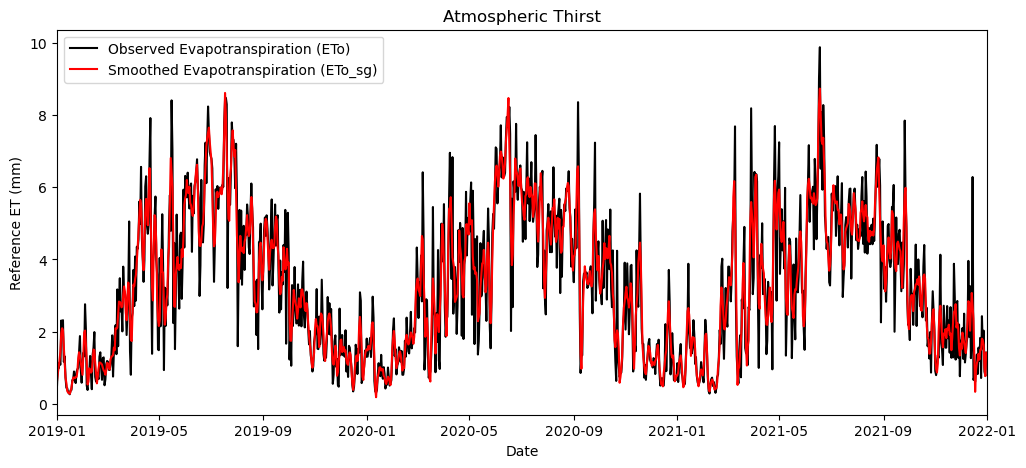

In [7]:
# Plot observed ETo and the smoothed (ETo_sg) data using a line plot.
# Use timestamp in the x-axis. Your plot should span 3 years.
# Label axes and add legends as needed

plt.figure(figsize = (12, 5))
plt.title("Atmospheric Thirst")

plt.plot(df['Timestamp'], df['ETo'], color = 'k', label = 'Observed Evapotranspiration (ETo)')
plt.plot(df['Timestamp'], df['ETo_sg'], color = 'r', label = 'Smoothed Evapotranspiration (ETo_sg)')

plt.xlim(df['Timestamp'].min(), df['Timestamp'].min() + pd.DateOffset(years = 3))

plt.xlabel('Date')
plt.ylabel('Reference ET (mm)')
plt.legend()
plt.show()

In [8]:
# Define sinusoidal model that describes seasonal variations in evapotranspiration as a lambda function

sin_model = lambda t, A, B, C: A + B*np.cos(2*np.pi*(t-C)/365) + np.pi # np.random.normal(loc=0, scale=sigma) - random component 

In [9]:
# Fit model to observed data and print optimized parameters
# Print optimized paramter values

#Save variables with shorter names 
x_obs = df['DOY']
y_obs = df['ETo']

# Optimization parameter and varainace covariance
popt, pcov = curve_fit(sin_model, x_obs, y_obs)

# Print the parameters 
print(f'A - Annual Mean ETo: {round(popt[0], 3)} mm/Day')
print(f'B - Annual Amplitude on the ETo: {round(popt[1], 3)} mm/Day')
print(f'C - Phase Constant: {round(popt[2], 3)} Days')


A - Annual Mean ETo: 0.175 mm/Day
B - Annual Amplitude on the ETo: -2.195 mm/Day
C - Phase Constant: 4.677 Days


In [10]:
# Use model with optimized paramters to predict ETo at the same points in time to create a curve
# Add values of predicted ETo as a new column named 'ETo_pred'

# Prediction  
x_pred = df['DOY']
y_pred = sin_model(x_pred, *popt)

# Add the prediction in a dataframe column 
df["ETo_pred"] = y_pred 
df.head()

,Timestamp,ETo,ETo_sg,DOY,ETo_pred
0,2019-01-01,0.52,0.640238,1,1.125910
1,2019-01-02,1.12,0.854524,2,1.123844
2,2019-01-03,0.99,1.034524,3,1.122428
3,2019-01-04,1.15,1.221905,4,1.121662
4,2019-01-05,1.09,1.460000,5,1.121547


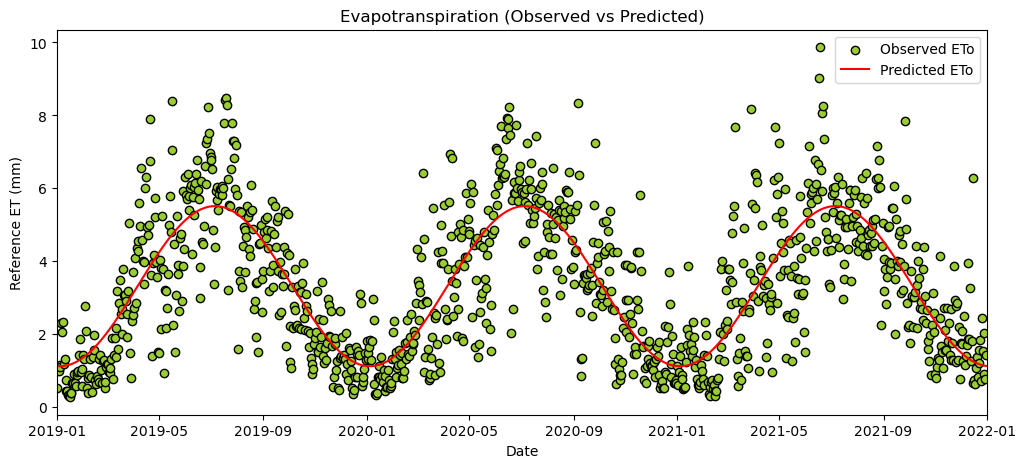

In [11]:
# Plot predicted values with the model (ETo_pred, line plot) and observed data (ETo, scatter plot).
# Use timestamp in the x-axis and add labels and legends as needed
# There is an example figure in Canvas to illustrate what your output should look like


# Figure with observed data and the model 

plt.figure(figsize = (12, 5))
plt.title("Evapotranspiration (Observed vs Predicted)")

plt.scatter(df['Timestamp'], df['ETo'], marker = 'o', facecolor = 'yellowgreen', edgecolor = 'k', label = 'Observed ETo')
plt.plot(df['Timestamp'], df['ETo_pred'], color = 'red', label = 'Predicted ETo')

plt.xlim(df['Timestamp'].min(), df['Timestamp'].min() + pd.DateOffset(years = 3))

plt.xlabel('Date')
plt.ylabel('Reference ET (mm)')
plt.legend()
plt.show()

In [12]:
# Calculate the goodness of fit using the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE)
# The two errors must be coded as lambda functions. No separate Python modules are allowed.
# In this cell code the lambda functions, compute the errors, and print their values with their respective units.

# Lambda function 

mae_fn = lambda y1,y2: np.round(np.mean(np.abs(y1-y2)),2)

rmse_fn = lambda y1,y2: np.sqrt(np.mean((y1-y2)**2))

# MAE code

MAE = mae_fn(y_obs, y_pred)
print('MAE is:',np.round(MAE,2), 'mm/Day')

# RMSE code

RMSE = rmse_fn(y_obs, y_pred)
print('RMSE is:',np.round(RMSE,2), 'mm/Day')

MAE is: 0.94 mm/Day
RMSE is: 1.26 mm/Day


In [13]:
# Subtract predicted values with the model (ETo_pred) from observed data (ETo) to obtain residuals
residuals = df['ETo'] - df['ETo_pred']

In [14]:
# Compute average (round to nearest integer) and standard deviation (round to 2 decimal places) of the residuals.
# Print these values with their respective units, e.g., MAE = 0.94 mm/day 

print(f'Average of Residuals: {np.round(np.mean(residuals), decimals =0)} mm/Day')
print(f'Standard Deviation of Residuals: {np.round(np.std(residuals), decimals =2)} mm/Day')


Average of Residuals: 0.0 mm/Day
Standard Deviation of Residuals: 1.26 mm/Day


In [18]:
# Test whether the residuals come from a normal distribution
stat, p = shapiro(residuals)

if p<0.05:
    print(f'Null hypothesis rejected - Residuals distribution is not normal, p-value: {np.round(p, 6)}')
else:
    print(f'Null hypothesis accepted - Residual distribution ins normal, p-value: {np.round(p, 6)}')     

Null hypothesis rejected - Residuals distribution is not normal, p-value: 0.0


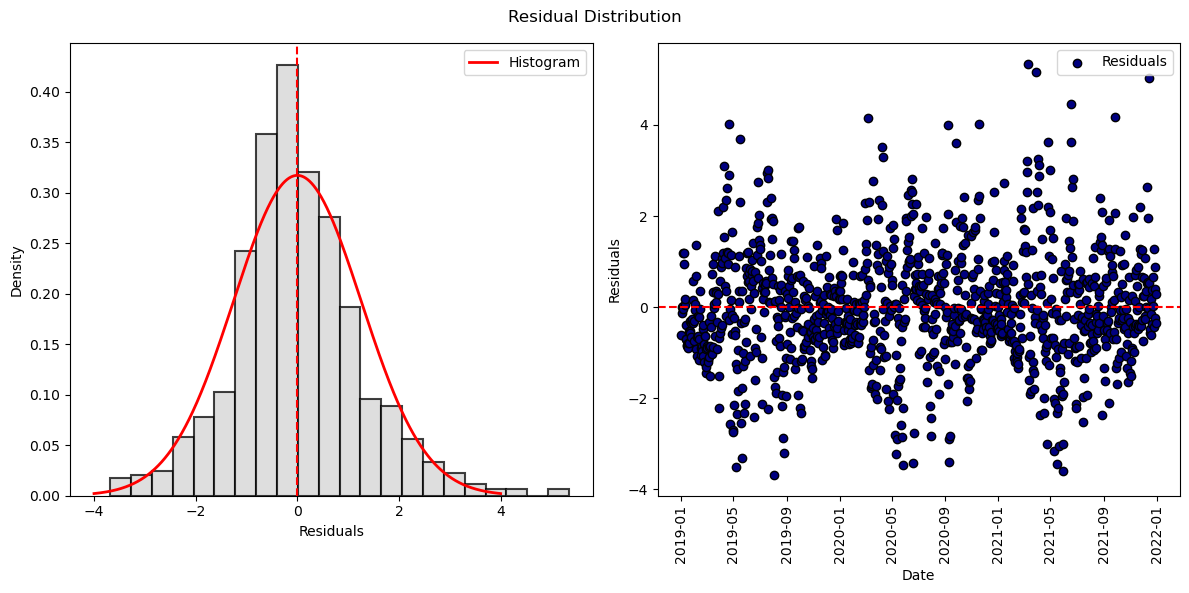

In [16]:
# Create a figure with two subplots (1 row and 2 columns) showing the residuals using a scatter plot and 
# the residual distribution using a histogram.
# For the scatter plot add a horiontal line at y=0
# For the histogram add a vertical line at x=0 and add a normal probability density function (Hint: scipy.stats.norm)

plt.figure(figsize = (12, 6))

plt.suptitle('Residual Distribution')

# subplot 1 - Histogram
plt.subplot(1, 2, 1)
plt.hist(residuals, bins = 'scott',edgecolor = 'black', facecolor = 'lightgray',alpha = 0.75, linewidth = 1.5,
         density = True);
plt.axvline(x=0, color='red', linestyle='--')
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x, np.mean(residuals), np.sqrt(np.var(residuals)))
plt.plot(x ,y, color = 'red', linewidth = 2, label = 'Histogram')

plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

# subplot 2 - Scatterplot
plt.subplot(1, 2, 2)
plt.scatter(df["Timestamp"], residuals, marker = "o", facecolor = 'navy', edgecolor = 'k', label = "Residuals")
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.xticks(rotation=90, ha='center')

plt.tight_layout()

plt.show()

## Answer the following questions

*Q1: Does the provided model fit the data well? Justify your answer.* 



Yes, I believe the provided model fit the data well. The commonly used metrics MAE (Mean Absolute Error - 0.93 mm/Day) and RMSE (Root Mean Squared Error - 1.25 mm/day) are low compared to summary statistics / range of values of the data set(specific to our dataset). This suggests that the model can make predictions for evapotranspiration within reasonalbel accuracy. The graphical results obtained for observed vs predicted evapotranspiration also corroborate our claim of a good fit.  

*Q2: Is the mean of the residuals equal to zero? Does the distribution of residuals meet the assumption of normality?*


The residuals have a mean value of 3.3003735161463155e-11, which is close to zero but not exactly zero. No, based on Shapiro Wilk's test for normality, the residuals do not meet the assumption of normality. 

*Q3: Is there any evidence of additional information in the residuals that could be exploited to improve the model?*

We can get two additional information from the residuals that could be used to improve the model:

- Every year, from May to August, the data seems to have peaked. Its a repeating pattern which may suggest some seasonal/cyclic effect on evapotranspiration. We could add a sesonal component or a cyclic component to our model to better capture the trend and improve predictions 
- The residual plot also reveals some observations that are outside the three sigma threshold (extreme right of histogram). These could be potential outliers and require further investigation.

 *Q4: Briefly interpret model parameters*


$$ ET_o(t) = A + B \ cos \bigg(2 \pi \frac{t-C}{365} \bigg) + \pi + \epsilon ~(0,\sigma)$$

- The annual mean of $ET_o$ represented by $A$ in the model is 0.175 mm/Day. This represents the average evapotranspiration over the year, the baseline.  
- The annual amplitude of $ET_o$ represented by $B$ in the model -2.195 mm/Day. The amplitude represents the difference in the maximum and minimum evapotranspiration over the year. The absolute amplitude is high compared to the annual mean, this indicates higher varition in evapotranspiration over the year.
- The phase constant $C$ is 4.67, which means that the maximum atmospheric demand occurs on July 4 or July 5. 